In [1]:
import numpy, pandas, emat
from matplotlib import pyplot as plt

/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
logger = emat.util.loggers.log_to_stderr(20, True)

In [84]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
def core1(x1=0, x2=0):
    return numpy.sin(x1) + x1

In [5]:
def core2(x1=0, x2=0):
    return numpy.sin(x1) + numpy.sin(x1*3)/3 + numpy.sin(x1*5)/5 + numpy.sin(x1*7)/7 + numpy.sin(x1*9)/9 + numpy.cos(x2)*4

In [6]:
def core_f(x1,x2):
    return {'Aa':core1(x1, x2), 'Bb':core2(x1, x2)}

In [7]:
a = numpy.linspace(0,10,1000)

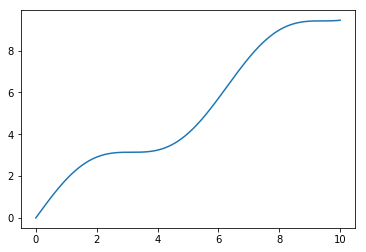

In [8]:
plt.plot(a, core1(a,0));

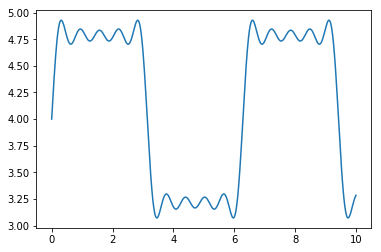

In [9]:
plt.plot(a, core2(a,0));

In [10]:
scope_def="""---
scope:
    name: simplistic
inputs:
    x1:
        ptype: exogenous uncertainty
        default: 0
        min: 0.0
        max: 10.0
        dist:
            name: pert
            peak: 3
            gamma: 4
    x2:
        ptype: policy lever
        default: 1.0
        min: 0.0
        max: 10.0
outputs:
    Aa:
        kind: minimize
    Bb:
        kind: maximize
...
"""

In [11]:
s = emat.Scope(scope_file="/tmp/simple-scope.yaml", scope_def=scope_def)

In [12]:
db = emat.SQLiteDB()

[00:09.03] MainProcess/INFO: running script scope.sql
[00:09.04] MainProcess/INFO: running script exp_design.sql
[00:09.04] MainProcess/INFO: running script meta_model.sql


In [13]:
s.store_scope(db)

In [14]:
from emat.experiment.experimental_design import design_experiments
design = design_experiments(s, n_samples_per_factor=10, sampler='lhs', db=db, random_seed=1)
design

,x1,x2
experiment,,
1,1.891758,2.611062
2,5.368385,7.036682
3,2.730809,9.234619
4,3.516953,3.548086
5,1.586794,6.451685
6,4.740627,4.559745
7,2.133715,1.262400
8,5.765793,6.541812
9,2.810613,8.458431


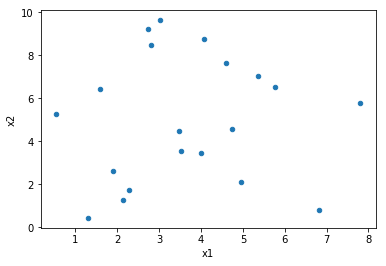

In [15]:
design.plot.scatter('x1','x2')

In [16]:
from emat.model.core_python import PythonCoreModel
m = PythonCoreModel(core_f, scope=s, db=db)

In [17]:
m

<emat.PythonCoreModel "EMAT", metamodel_id=None with 1 uncertainties, 1 levers, 2 measures>

In [18]:
from ema_workbench import SequentialEvaluator

In [19]:
with SequentialEvaluator(m) as eval_seq:
    lhs_results = m.run_experiments(design_name='lhs', evaluator=eval_seq)
lhs_results.head()

[00:09.49] MainProcess/INFO: performing 20 scenarios/policies * 1 model(s) = 20 experiments
[00:09.50] MainProcess/INFO: performing experiments sequentially
[00:09.51] MainProcess/INFO: 2 cases completed
[00:09.51] MainProcess/INFO: 4 cases completed
[00:09.52] MainProcess/INFO: 6 cases completed
[00:09.52] MainProcess/INFO: 8 cases completed
[00:09.52] MainProcess/INFO: 10 cases completed
[00:09.52] MainProcess/INFO: 12 cases completed
[00:09.52] MainProcess/INFO: 14 cases completed
[00:09.53] MainProcess/INFO: 16 cases completed
[00:09.53] MainProcess/INFO: 18 cases completed
[00:09.53] MainProcess/INFO: 20 cases completed
[00:09.54] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
experiment,,,,
1,1.891758,2.611062,2.840691,-2.716609
2,5.368385,7.036682,4.575944,2.073529
3,2.730809,9.234619,3.130137,-3.058060
4,3.516953,3.548086,3.150345,-4.576476
5,1.586794,6.451685,2.586666,4.777632


In [20]:
lhs_results

,x1,x2,Aa,Bb
experiment,,,,
1,1.891758,2.611062,2.840691,-2.716609
2,5.368385,7.036682,4.575944,2.073529
3,2.730809,9.234619,3.130137,-3.058060
4,3.516953,3.548086,3.150345,-4.576476
5,1.586794,6.451685,2.586666,4.777632
6,4.740627,4.559745,3.741026,-1.441147
7,2.133715,1.262400,2.979416,2.047806
8,5.765793,6.541812,5.271178,3.110677
9,2.810613,8.458431,3.135583,-1.346845


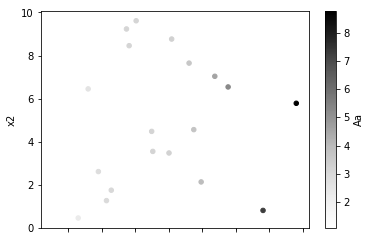

In [21]:
lhs_results.plot.scatter('x1','x2',c='Aa');

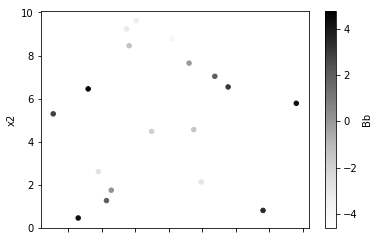

In [22]:
lhs_results.plot.scatter('x1','x2',c='Bb');

In [23]:
mm = m.create_metamodel_from_design('lhs')
mm

<emat.PythonCoreModel "EMATMeta", metamodel_id=1 with 1 uncertainties, 1 levers, 2 measures>

In [24]:
cv_initial = mm.function.cross_val_scores()

In [25]:
cv_initial

Aa    0.871353
Bb    0.891439
dtype: float64

In [26]:
dict(1-cv_initial)

{'Aa': 0.12864665374706497, 'Bb': 0.10856050140667606}

In [27]:

        
from emat.experiment.experimental_design import minimum_weighted_distance, batch_pick_new_experiments
    

In [28]:
n_augmentations = 4
batch_size = 8

In [29]:
aug_design = {}
aug_results = {}
design_names = ['lhs',]
aug_mm = {-1: mm}
aug_cv = {-1: cv_initial}

[00:19.93] MainProcess/INFO: output_focus = {'Aa': 0.12864665374706497, 'Bb': 0.10856050140667606}
[00:19.93] MainProcess/INFO: length_scales =
           Aa        Bb
x1   1.948737  3.532483
x2  21.641422  1.527635
[00:19.94] MainProcess/INFO: dimension_weights = [0.09674746 0.07700887]
[00:20.14] MainProcess/INFO: Selecting 4125
[00:20.23] MainProcess/INFO: Selecting 428
[00:20.32] MainProcess/INFO: Selecting 3260
[00:20.40] MainProcess/INFO: Selecting 2693
[00:20.50] MainProcess/INFO: Selecting 2111
[00:20.59] MainProcess/INFO: Selecting 281
[00:20.67] MainProcess/INFO: Selecting 2933
[00:20.77] MainProcess/INFO: Selecting 2723
[00:20.99] MainProcess/INFO: Replacing 428 with 4743
[00:21.35] MainProcess/INFO: Replacing 2933 with 1727
[00:21.42] MainProcess/INFO: 2 Fedorov Exchanges completed.
[00:21.96] MainProcess/INFO: 0 Fedorov Exchanges completed.


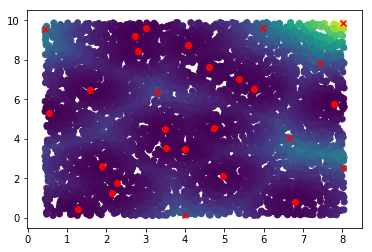

[00:22.31] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[00:22.32] MainProcess/INFO: performing experiments sequentially
[00:22.32] MainProcess/INFO: 1 cases completed
[00:22.33] MainProcess/INFO: 2 cases completed
[00:22.33] MainProcess/INFO: 3 cases completed
[00:22.34] MainProcess/INFO: 4 cases completed
[00:22.34] MainProcess/INFO: 5 cases completed
[00:22.35] MainProcess/INFO: 6 cases completed
[00:22.35] MainProcess/INFO: 7 cases completed
[00:22.35] MainProcess/INFO: 8 cases completed
[00:22.35] MainProcess/INFO: experiments finished
[00:35.48] MainProcess/INFO: output_focus = {'Aa': 1.6846473451792576e-06, 'Bb': 0.14624013689244664}
[00:35.49] MainProcess/INFO: length_scales =
            Aa        Bb
x1    2.191805  2.970502
x2  135.149010  1.520172
[00:35.49] MainProcess/INFO: dimension_weights = [0.04923155 0.09619973]
[00:35.66] MainProcess/INFO: Selecting 2468


Aa    0.999998
Bb    0.853760
dtype: float64


[00:35.74] MainProcess/INFO: Selecting 1495
[00:35.83] MainProcess/INFO: Selecting 4712
[00:35.91] MainProcess/INFO: Selecting 4123
[00:35.98] MainProcess/INFO: Selecting 54
[00:36.07] MainProcess/INFO: Selecting 2243
[00:36.16] MainProcess/INFO: Selecting 3784
[00:36.23] MainProcess/INFO: Selecting 2311
[00:36.79] MainProcess/INFO: 0 Fedorov Exchanges completed.


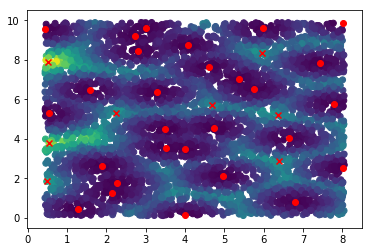

[00:37.16] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[00:37.17] MainProcess/INFO: performing experiments sequentially
[00:37.17] MainProcess/INFO: 1 cases completed
[00:37.17] MainProcess/INFO: 2 cases completed
[00:37.18] MainProcess/INFO: 3 cases completed
[00:37.18] MainProcess/INFO: 4 cases completed
[00:37.18] MainProcess/INFO: 5 cases completed
[00:37.18] MainProcess/INFO: 6 cases completed
[00:37.19] MainProcess/INFO: 7 cases completed
[00:37.19] MainProcess/INFO: 8 cases completed
[00:37.19] MainProcess/INFO: experiments finished
[00:54.39] MainProcess/INFO: output_focus = {'Aa': 4.257903513105177e-07, 'Bb': 0.17030454564017095}
[00:54.40] MainProcess/INFO: length_scales =
            Aa        Bb
x1    2.156134  2.752669
x2  104.423693  1.324391
[00:54.40] MainProcess/INFO: dimension_weights = [0.06186907 0.1285908 ]
[00:54.57] MainProcess/INFO: Selecting 287


Aa    1.000000
Bb    0.829695
dtype: float64


[00:54.65] MainProcess/INFO: Selecting 4090
[00:54.74] MainProcess/INFO: Selecting 2270
[00:54.82] MainProcess/INFO: Selecting 4696
[00:54.90] MainProcess/INFO: Selecting 1781
[00:55.00] MainProcess/INFO: Selecting 1743
[00:55.09] MainProcess/INFO: Selecting 4285
[00:55.19] MainProcess/INFO: Selecting 2170
[00:55.79] MainProcess/INFO: 0 Fedorov Exchanges completed.


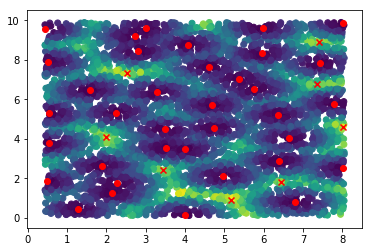

[00:56.21] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[00:56.24] MainProcess/INFO: performing experiments sequentially
[00:56.24] MainProcess/INFO: 1 cases completed
[00:56.25] MainProcess/INFO: 2 cases completed
[00:56.26] MainProcess/INFO: 3 cases completed
[00:56.26] MainProcess/INFO: 4 cases completed
[00:56.27] MainProcess/INFO: 5 cases completed
[00:56.27] MainProcess/INFO: 6 cases completed
[00:56.28] MainProcess/INFO: 7 cases completed
[00:56.29] MainProcess/INFO: 8 cases completed
[00:56.29] MainProcess/INFO: experiments finished
[01:16.86] MainProcess/INFO: output_focus = {'Aa': 4.5891845878998083e-10, 'Bb': 0.05560308293374294}
[01:16.88] MainProcess/INFO: length_scales =
            Aa        Bb
x1    2.212975  1.773213
x2  252.196441  1.541677
[01:16.88] MainProcess/INFO: dimension_weights = [0.03135724 0.03606663]


Aa    1.000000
Bb    0.944397
dtype: float64


[01:17.13] MainProcess/INFO: Selecting 1472
[01:17.22] MainProcess/INFO: Selecting 1523
[01:17.39] MainProcess/INFO: Selecting 3106
[01:17.50] MainProcess/INFO: Selecting 4183
[01:17.61] MainProcess/INFO: Selecting 4160
[01:17.72] MainProcess/INFO: Selecting 453
[01:17.79] MainProcess/INFO: Selecting 3184
[01:17.88] MainProcess/INFO: Selecting 4879
[01:18.04] MainProcess/INFO: Replacing 1472 with 1439
[01:18.14] MainProcess/INFO: Replacing 1523 with 808
[01:18.58] MainProcess/INFO: 2 Fedorov Exchanges completed.
[01:19.24] MainProcess/INFO: 0 Fedorov Exchanges completed.


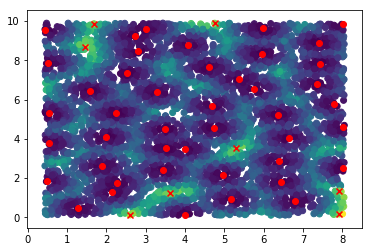

[01:19.67] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[01:19.68] MainProcess/INFO: performing experiments sequentially
[01:19.68] MainProcess/INFO: 1 cases completed
[01:19.69] MainProcess/INFO: 2 cases completed
[01:19.69] MainProcess/INFO: 3 cases completed
[01:19.70] MainProcess/INFO: 4 cases completed
[01:19.70] MainProcess/INFO: 5 cases completed
[01:19.70] MainProcess/INFO: 6 cases completed
[01:19.70] MainProcess/INFO: 7 cases completed
[01:19.70] MainProcess/INFO: 8 cases completed
[01:19.71] MainProcess/INFO: experiments finished


Aa    1.000000
Bb    0.912193
dtype: float64


In [30]:
for aug in range(n_augmentations):
    design_pool = design_experiments(s, n_samples=5000, sampler='ulhs98', random_seed=42+aug)
    aug_design[aug] = aug_mm[aug-1].function.pick_new_experiments(
            design_pool,
            batch_size=batch_size,
            output_focus=dict(1-aug_cv[aug-1]),
            scope=s,
            db=db,
            design_name=f'aug_{aug}',
            debug=('x1','x2'),
    )
    with SequentialEvaluator(m) as eval_seq:
        aug_results[aug] = m.run_experiments(design_name=f'aug_{aug}', evaluator=eval_seq)
    design_names.append(f'aug_{aug}')
    aug_mm[aug] = m.create_metamodel_from_designs(design_names)
    aug_cv[aug] = aug_mm[aug].function.cross_val_scores()
    print(aug_cv[aug])

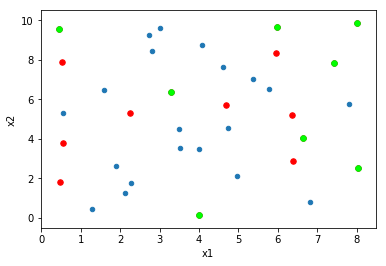

In [31]:
ax = design.plot.scatter('x1','x2')
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#A00000', s=30)
ax = aug_design[1].plot.scatter('x1','x2', ax=ax, c='#FF0000', s=30)
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#00FF00', s=30)



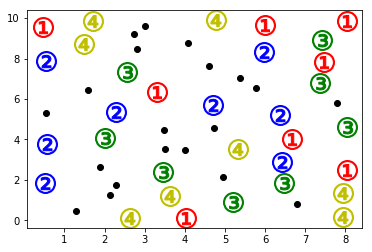

In [32]:
plt.plot(design.x1, design.x2, 'ko')
plt.plot(aug_design[0].x1, aug_design[0].x2, "ro", marker=r'$①$', markersize=22)
plt.plot(aug_design[1].x1, aug_design[1].x2, "bo", marker=r'$②$', markersize=22)
plt.plot(aug_design[2].x1, aug_design[2].x2, "go", marker=r'$③$', markersize=22)
plt.plot(aug_design[3].x1, aug_design[3].x2, "yo", marker=r'$④$', markersize=22)

In [33]:
# TEST

In [70]:
testdesign = design_experiments(s, n_samples=10000, sampler='lhs', random_seed=123)

In [71]:
testresults_core = m.run_experiments(design=testdesign, db=False)
testresults_core.head()

[44:14.56] MainProcess/INFO: performing 10000 scenarios/policies * 1 model(s) = 10000 experiments
[44:14.58] MainProcess/INFO: performing experiments sequentially
[44:14.82] MainProcess/INFO: 1000 cases completed
[44:15.06] MainProcess/INFO: 2000 cases completed
[44:15.27] MainProcess/INFO: 3000 cases completed
[44:15.48] MainProcess/INFO: 4000 cases completed
[44:15.71] MainProcess/INFO: 5000 cases completed
[44:15.93] MainProcess/INFO: 6000 cases completed
[44:16.14] MainProcess/INFO: 7000 cases completed
[44:16.36] MainProcess/INFO: 8000 cases completed
[44:16.57] MainProcess/INFO: 9000 cases completed
[44:16.79] MainProcess/INFO: 10000 cases completed
[44:16.79] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
0,2.333052,1.302828,3.056332,1.854069
1,0.904135,1.589445,1.690025,0.766896
2,6.924605,6.559052,7.522939,4.553108
3,0.782577,5.090140,1.487686,2.252265
4,3.093514,6.701449,3.141574,3.892541


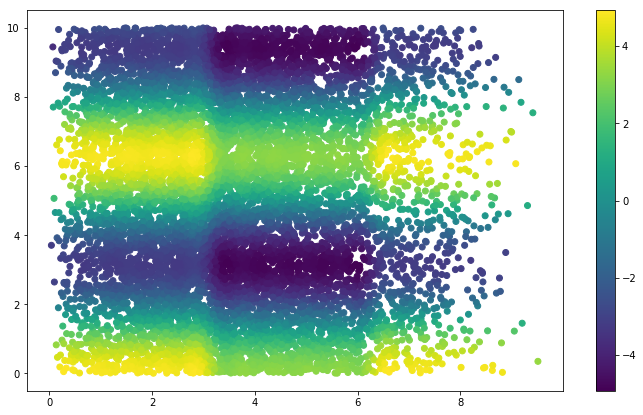

In [72]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Bb)
plt.colorbar(scat)

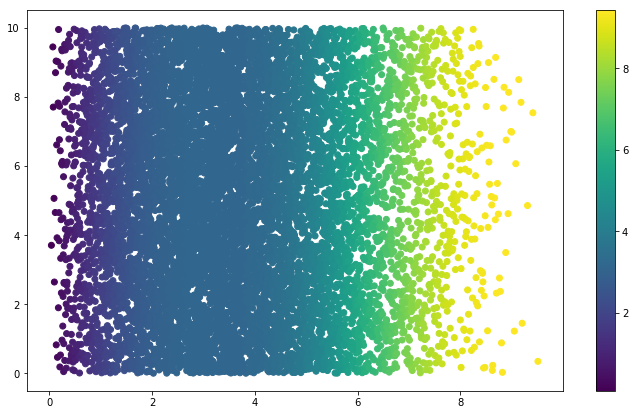

In [73]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Aa)
plt.colorbar(scat)

In [75]:
testresults_3 = aug_mm[3].run_experiments(design=testdesign, db=False)
testresults_3.head()

[46:14.09] MainProcess/INFO: performing 10000 scenarios/policies * 1 model(s) = 10000 experiments
[46:14.10] MainProcess/INFO: performing experiments sequentially
[46:18.71] MainProcess/INFO: 1000 cases completed
[46:22.89] MainProcess/INFO: 2000 cases completed
[46:27.74] MainProcess/INFO: 3000 cases completed
[46:32.62] MainProcess/INFO: 4000 cases completed
[46:37.50] MainProcess/INFO: 5000 cases completed
[46:42.15] MainProcess/INFO: 6000 cases completed
[46:46.57] MainProcess/INFO: 7000 cases completed
[46:51.78] MainProcess/INFO: 8000 cases completed
[47:05.09] MainProcess/INFO: 9000 cases completed
[47:13.42] MainProcess/INFO: 10000 cases completed
[47:13.42] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
0,2.333052,1.302828,3.056332,1.793004
1,0.904135,1.589445,1.690028,0.696702
2,6.924605,6.559052,7.522941,4.366080
3,0.782577,5.090140,1.487690,2.726669
4,3.093514,6.701449,3.141576,3.462648


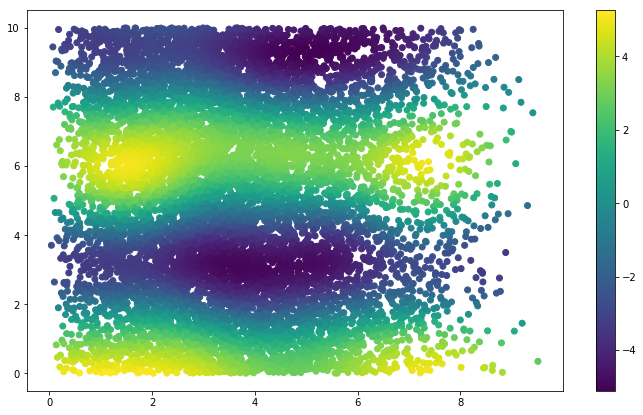

In [76]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_3.x1, testresults_3.x2, c=testresults_3.Bb)
plt.colorbar(scat)

In [77]:
testresults_3['BbZ'] = testresults_core.Bb

In [78]:
aug_mm[3].function(x1=1.312643, x2=9.547349)

{'Aa': 2.279510255867688, 'Bb': -3.185202428347708}

In [79]:
m.function(x1=1.312643, x2=9.547349)

{'Aa': 2.2795060738394026, 'Bb': -3.2286233990651425}

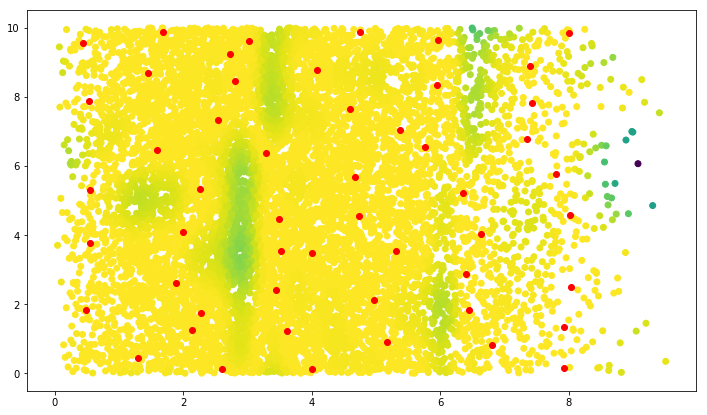

In [80]:
plt.figure(figsize=(12,7))

plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=(testresults_3['Bb'] - testresults_3['BbZ'])**2, 
    cmap='viridis_r',
)


plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)

In [81]:
testresults_3['std_Aa'] = testresults_3[['x1','x2']].apply(
    lambda x: mm.function.compute_std(**x)['Aa'], 
    axis=1,
)

/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/jpn/anaconda/envs/EMAT/lib/python3.6/site-packages/sklearn/gaussian_process/g

In [85]:
testresults_3['std_Bb'] = testresults_3[['x1','x2']].apply(
    lambda x: mm.function.compute_std(**x)['Bb'], 
    axis=1,
)

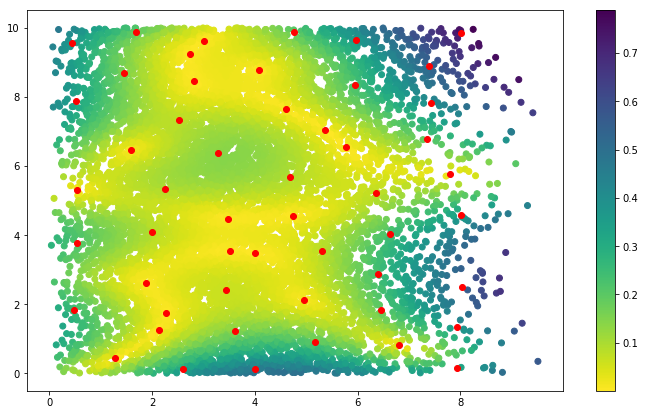

In [86]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Bb'], 
    cmap='viridis_r',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)



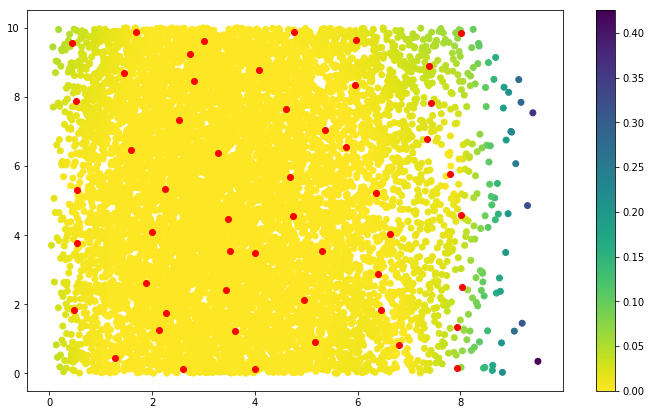

In [87]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Aa'], 
    cmap='viridis_r',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)


